# Final Exam - PHYS 512
Laura Gonzalez Escudero

## 1. Finite difference with complex variables

### (a) Define derivatives function

$$
\dfrac{df}{dx} = \dfrac{\text{Im}\left[f(x+ih)\right]}{h}
$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#forward differentiation
def deriv(func, x, h):
    '''This function computes derivative df/dx using complex variables
       f = func 
       x = value where derivative is calculated
       h = step-size
       Returns the numerical value of the derivative'''
    
    #take step x -> x + ih
    hIm = complex(0,h)
    df_dx = func(x+hIm).imag/h
    
    return df_dx

### (b) Evaluate derivative of sin$^3$x at x=1.5 as a function of h

**Centered difference**
$$
\dfrac{df}{dx} = \dfrac{f(x+h)-f(x-h)}{2h}
$$

In [12]:
def deriv_center(func, x, h):
    '''Implement a second derivative method df/dx that uses a 
    centered difference
    '''
    #Regular approach (Not imaginary)
    #hIm = complex(0,h)
    
    df_dx = (func(x+h) - func(x-h))/(2*h)
    return df_dx

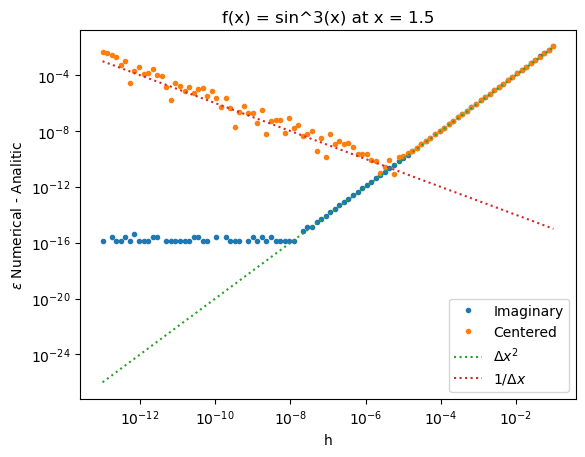

In [24]:
#h_array = np.logspace(-10, 2, 20)

#define step size
h_array = 10**np.linspace(-13, -1, 100)


def sine_cube(x):
    '''Define function to differentiate'''
    return np.sin(x)**3



frac_diff_num = []
frac_diff_center = []
df_analitic = 3*np.cos(1.5)*(np.sin(1.5)**2)

for h in h_array:
    df_num = deriv(sine_cube, 1.5, h)
    df_num_center = deriv_center(sine_cube, 1.5, h)
    frac_diff_num.append(np.abs((df_num - df_analitic)/df_analitic))
    frac_diff_center.append(np.abs((df_num_center - df_analitic)/df_analitic))
    
    
    
#plot fractional error

#ax.plot(h_array, df_num, label='Numeric')
#ax.plot(h_array, df_num_center, label='Numeric Centered')
#ax.plot(h_array, df_analitic, label='Analitic')
plt.title('f(x) = sin^3(x) at x = 1.5')
plt.plot(h_array, frac_diff_num, '.', label='Imaginary')
plt.plot(h_array, frac_diff_center, '.', label='Centered')
plt.plot(h_array, h_array**2, label=r'$\Delta x^2$', linestyle=':')
plt.plot(h_array, 10e-17/h_array, label=r'$1/\Delta x$', linestyle=':')
plt.xlabel('h')
plt.ylabel('$\epsilon$ Numerical - Analitic')
plt.legend()
plt.yscale('log')
plt.xscale('log')

### Discuss results and explain behaviour you see:

The **centered differentiation** curve in orange is a second order method and matches the expected behaviour, as seen in class. First, it decreases with increasing stepsize following $1/\Delta x$ until it reaches an optimal step size around $10^{-6}$ before the curve goes up again. At this point, the truncation error starts to dominates the total error. So, for larger step sizes the precision is reduced and we see the error increasing again after $\ge 10^{-6}$.


The **imaginary step** method is also a second order method, but follows a slightly different behaviour as shown above. We observe that it is subject to round-off error at small stepsizes. Up to $10^{-8}$ all the errors are at round-off, which might be due to the fact that we cannot measure anything below round-off. In fact, the method could have some structure in that region, but not perceivable. The optimal stepsize for this method is $10^{-8}$, smaller than for the centered differentiation. Then, with increasing stepsize, the accuracy decreases due to truncation errors, which again dominate the total error. For these larger stepsizes, we see the normal $\Delta x^2$ behaviour of a second order method. 

The two methods have a different truncate error vs round-off error tradeoff, resulting in the different behaviours plotted above. 

## 2. Time-independent Schroedinger Equation

$$
-\dfrac{\hbar^2}{2m}\dfrac{d^2\Psi}{dx^2} - e^\left(-\sqrt{|x|}\right)\Psi = E\Psi
$$

Find solution $\Psi$ using the shooting method and by imposing that the wavefunction must match at the boundaries as well as imposing that the wavefunction decays to zero $\Psi \rightarrow 0$ at the boundaries, which i set to be $-20$ and $20$. 

We can then explore taking $x \rightarrow \inf$ to have a larger grid.

**Shooting method**

To implement this method, I consulted ChatGPT (but it wasn't too useful) and Bachelor Thesis by Tu Wien (url: https://www.iue.tuwien.ac.at/uploads/tx_sbdownloader/Bachelor-Arbeit_Marie_ERTL_09-2016.pdf). Inspired by his shooting method approach for the Quantum Harmonic Oscillator. 

Rewrite S.E as two first order ODEs using

$$
\dfrac{d\Psi}{dx} = g
$$

$$
\dfrac{dg}{dx} = -\dfrac{2m}{\hbar^2}\left[-V(x) + E\right]\Psi
$$

$$
\dfrac{dg}{dx} = \dfrac{2m}{\hbar^2}\left[V(x) - E\right]\Psi
$$

$$
\dfrac{dg}{dx} = \dfrac{2m}{\hbar^2}\left[-e^\left(-\sqrt{|x|}\right) - E\right]\Psi
$$


In [26]:
import scipy.integrate
from scipy.optimize import newton


def potential(x):
    '''Define 1D potential'''
    return -np.exp(-np.sqrt(np.abs(x)))


def schroedinger_eq(x, y, E):
    '''Define Schroedinger Equation with potential function and eigenvalue E.
       Use CGS units where hbar = 1 and consider a particle of mass m=1
       
       This function returns an array of two first order ODEs as defined above'''
    m = 1.0
    hbar = 1.0
    
    psi, g = y
    dpsi_dx = g
    dg_dx = -(2*m / hbar**2) * (-potential(x) + E)*psi
    return np.asarray([dpsi_dx, dg_dx])



#I will use a Runge-Kutta method for integration
def rk4(f, psi0, x, E):
    '''Fourth order Runge Kutta
       Integrate function f (Schroedinger equ) with initial value psi0
       
       Taken from class notes'''
    
    nsteps = len(x)
    psi = np.array([psi0]*nsteps)    
    
    for i in range(1, nsteps):  
        #i = i+1
        h = x[i] - x[i-1]
        
        f0 = f(x[i-1], psi[i], E)
        y1 = psi[i-1] + h/2*f0
        f1 = f(x[i-1] + h/2, y1, E)
        y2 = psi[i-1] + h/2*f1
        f2 = f(x[i-1] + h/2, y2, E)
        y3 = psi[i-1] + h*f2
        f3 = f(x[i-1] + h, y3, E)
        
        psi[i] = psi[i-1] + h*(f0 + 2*f1 + 2*f2 + f3)/6
    return psi



def shoot(func, psi0, x, E_array):
    '''The shooting method calls the Runge Kutta function for integration
       
       func = Schroedinger equation to solve
       psi0 = initial conditions on left side (boundary)
       E_array = array of energy values
       
       This function integrates psi for every value of E in E_array'''
    
    psi_right = [] #wavefunction on right boundary
    
    for E in E_array:
        #call rk4
        psi = rk4(func, psi0, x, E)
        psi_right.append(psi[len(psi)-1][0])
    return np.asarray(psi_right)



def shoot1(E, func, psi0, x):
    '''Shooting method for one single energy value'''
    psi = rk4(func, psi0, x, E)
    return psi[len(psi)-1][0]



def findZeros(right_wavefunction):
    '''Find zeros of a function (wavefunction array) by identifying a sign flip,
       which is indicative of the function crossing the axis'''
    
    return np.where(np.diff(np.signbit(right_wavefunction)))[0]



def optimizeEnergy(func, psi0, x, E_array):
    '''Function optimized energy values using scipy.optimize's newton method 
       to find the roots of a function.
       
       1. Call shoot method that integrates psi for all Es in E_array
       2. Find the roots (guesses close to eigenvalues)
       3. Use newton function to find eigenvalues
       
       This function returns the optimized roots of psi, which are its eigenenergies'''
    
    #call shooting method
    shoot_try = shoot(func, psi0, x, E_array)
    
    #find zeros
    zeros = findZeros(shoot_try)
    
    energy = []
    for z in zeros:
        #find the 
        energy.append(newton(shoot1, E_array[z], args=(func, psi0, x)))
    return np.asarray(energy)



def normalized(wavefunc, dx):
    '''Normalize a wavefunction'''
    normal_factor = np.sqrt(np.trapz(np.abs(wavefunc)**2, dx=dx))
    return wavefunc/normal_factor

In [83]:
# set up problem

#initial conditions
psi0 = 0.0
g0 = 1.0
y0 = np.asarray([psi0, g0])
grid_size = 200.
stepsize = 1.0/grid_size

#grid
L = 20
x_range = np.arange(-L, L+stepsize, stepsize)

#initial guesses
E_guesses = np.arange(-1.0, 1.0, 0.01)


#get eigenvalues
eigE = optimizeEnergy(schroedinger_eq, y0, x_range, E_guesses)


eigW = []
for eE in eigE:
    #integrate using this eigenvalue by calling R-K integrator
    wf_temp = rk4(schroedinger_eq, y0, x_range, eE)
    eigW.append(normalized(wf_temp[:, 0], stepsize))

#put all eigenfunctions together
final_W = np.asarray(eigW)
#print(final_W)

Eigenvalues found: 
 [-0.32736898 -0.07783408 -0.03268324  0.0041015   0.0335222   0.08454454
  0.13249009  0.20427252  0.27061375  0.36124939  0.44603446  0.55466337
  0.6579147   0.78415419  0.90584064]


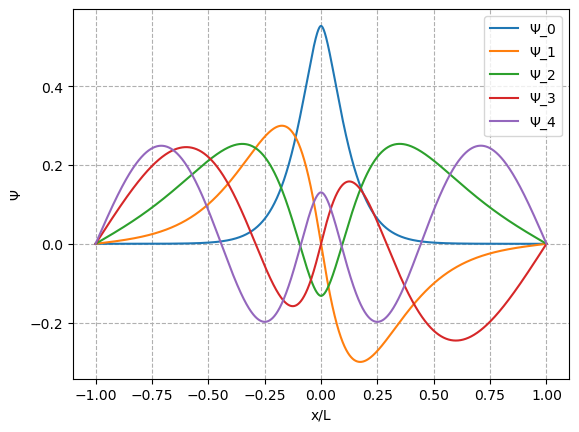

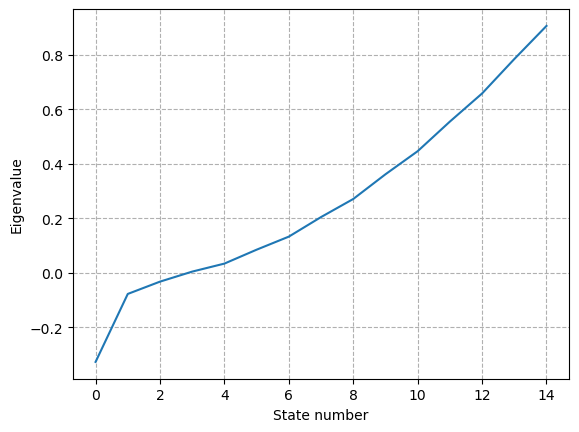

In [81]:
#plot wavefunction
print('Eigenvalues found: \n', eigE)

for i, eE in enumerate(eigE[:5]):
    plt.plot(x_range/20, final_W[i], label=r'$\Psi$_'+str(i))
plt.legend()
plt.grid(linestyle='--')
plt.xlabel('x/L')
plt.ylabel(r'$\Psi$')
plt.show()

#plot eigenvalues
plt.plot(eigE)
plt.xlabel('State number')
plt.ylabel('Eigenvalue')
plt.grid(linestyle='--')

We find the ground state energy to be $-0.327$. 

### Eigenvalue Accuracy

To estimate the accuracy in the eigenvalue found for the ground state, we can compare the eigenvalue obtained with different numerical resolutions. To do this, vary the grid size and observe how the eigenvalue changed. Then, compare these values.

**Note**: In the code, variable grid_size is used to change the stepsize, which determines how fine a grid is. So, I won't be changing how large the grid itself is, but how densely populated with gridpoints it is, therefore changing the accuracy of results. 

In [263]:
grid_sizes = [100., 200., 300.]

for g in grid_sizes:
    stepsize = 1./g
    x = np.arange(-L, L+stepsize, stepsize)
    #get eigenvalues
    eigE = optimizeEnergy(schroedinger_eq, y0, x, E_guesses)

    #eigW = []
    #for eE in eigE:
        #integrate using this eigenvalue
        #wf_temp = rk4(schroedinger_eq, y0, x, eE)
        #eigW.append(normalized(wf_temp[:, 0], stepsize))

    print('Eigenvalue E0 found for grid = '+str(g)+': ', eigE[0])

Eigenvalue E0 found for grid = 100.0:  -0.3273665303525028
Eigenvalue E0 found for grid = 200.0:  -0.32736898264971903
Eigenvalue E0 found for grid = 300.0:  -0.3273696172957691


We will analyse convergence behavior by taking finer grids. The assumption is that as grid size (grid density) increases, the eigenvalue should converge to a certain value. So, take the last eigenvalue computed for a grid size of 300.0 as the "reference" value, assuming the grid is sufficiently large and dense for the estimated energy to be more accurate. Now, compute errors comparing to this reference. 

In [273]:
E0s = np.asarray([-0.3273665303525028, -0.32736898264971903, -0.3273696172957691])
ref_E0 = E0s[-1]
error = np.abs(E0s[:2] - ref_E0)
print('Error = ', error)

#is error less than 1 part in 1000? 
print('The error is less than 1/1000 = ', error[:2]< 1/1000)

Error =  [3.08694327e-06 6.34646050e-07]
The error is less than 1/1000 =  [ True  True]


This shows that the energy of the ground state is accurate to at least 1 part in 1000, as required. 

## 3. Thermal Diffusion with insulating layer

We are solving thermal diffusion equation
$$
\dfrac{\partial T}{\partial t} = \kappa \dfrac{\partial^2 T}{\partial x^2}
$$

Using finite differences, 
$$
\dfrac{\partial T_i}{\partial t} = \kappa_i \dfrac{T_{i+1} -2T_i + T_{i-1}}{\Delta x^2}
$$

Using the backwards-Euler method, we can rewrite:

$$
T_i^n = -\alpha\kappa_i T_{i-1}^{n+1} + (1+2\alpha \kappa_i)T_I^{n+1} - \alpha \kappa_i T_{i+1}^{n+1} 
$$

Since the layer at x=0 is insulating we need to consider $dT_0/dx = 0$. Look at the update equation for the grid point at $i=1$:

$$
-\alpha\kappa_1 T_0^{n+1} + (1+2\alpha\kappa_1)T_1^{n+1} - \alpha\kappa_1 T_2^{n+1} = T_1^n
$$

An insulating layer means $T_0 = T_1$. So, the update equation for $i=1$ is:

$$
-\alpha\kappa_1 T_1^{n+1} + (1+2\alpha\kappa_1)T_1^{n+1} - \alpha\kappa_1T_2^{n+1} = T_1^n
$$

$$
(1+\alpha\kappa_1)T_1^{n+1} -\alpha\kappa_1 T_2^{n+1} = T_1^{n}
$$

This tells us we need to modify the top of the matrix so that the diagonal element is $(1+\alpha)$ instead of $(1+2\alpha)$. 

We should also set $dT_N/dt = 0$ since we are told that it is held at constant temperature. 

So, the matrix has the form:
$$
A = 
\begin{bmatrix}
0 & 1+\alpha\kappa_1 & -\alpha\kappa_1 & 0 &\dots & 0 & 0 \\
0 & -\alpha\kappa_2 & 1+2\alpha\kappa_2 & -\alpha\kappa_2 & 0 & \dots & 0 \\
& &\ddots& \ddots&\ddots \\ 
0 & 0 & 0 & 0 & \dots & 0 & 0 
\end{bmatrix}
$$

In [70]:
#load provided data

#insulated boundary and numerical stability notes

data = np.loadtxt('final_data.txt', delimiter = ' ')

N = len(data)
Ks = np.asarray(data[:,1])
Xs = np.asarray(data[:, 0])

In [71]:
import scipy.linalg

def matrices(K, n, alpha):
    '''This function constructs the temperature array T, matrix A
       and boundary vector bvec needed'''
    #temperature array
    
    #at t=0
    #initially, T=100K everywhere 
    T = np.zeros(n)+100

    #T(x=1) cooled down to 0K
    T[-1] = 0.0

    
    #construct matrix A
    #first diagonal
    a = -alpha * K * np.ones(n)
    a[0] = 0.0 #from equation found for T_1


    #center diagonal
    b = (1+2*K*alpha) * np.ones(n)
    #insulating boundary
    b[0] = 1+alpha*K[0]


    #last diagonal
    c = -alpha * K * np.ones(n)
    c[-1] = 0.0 #because it is kept at constant T

    AA = np.row_stack((a,b,c))
    
    #b vector -> boundaries
    bvec = np.zeros(n)
    bvec[-1] = 0
    return T, AA, bvec

After 1 second, 
 T =  [26.48013301 26.20183739 26.28330476 26.64608097 27.10624452 27.0767748
 24.10281036]


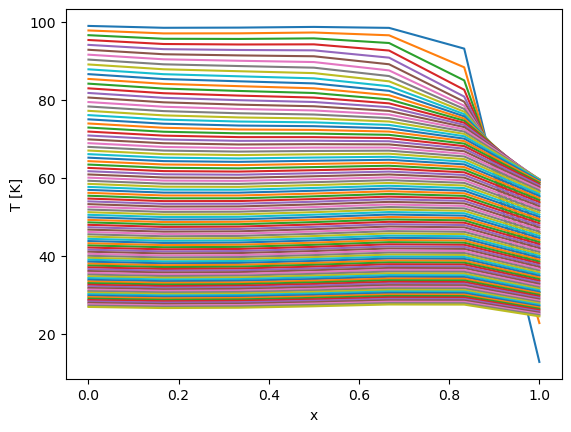

In [72]:
#call function

dt = 1e-2
tsteps = 1

dx1 = Xs[1]-Xs[0]
alpha1 = dt/dx1**2


T1, A1, b1 = matrices(Ks, N, alpha1)

#construct time array
time = np.arange(dt, tsteps+dt, dt)

for i in time:
    #solve
    T1 = scipy.linalg.solve_banded((1,1), A1, T1+alpha1*b1)
    if i == 1:
        print('After 1 second, \n T = ', T1)
        break
    plt.plot(Xs, T1, label=i)
plt.xlabel('x')
plt.ylabel('T [K]')
#plt.legend()
plt.show()

Observations:
* Due to having used only the provided x's and $\kappa$ values in the data file, the grid is very corse and the temperature profile shown above has low resolution. 
* The step dx is very large, causing the poor resolution seen above.
* One improvement can be to interpolate more values of $\kappa$. 

After 1 second, the temperature at the base (x=0) is **24.1K**, as shown above. 

### Interpolating $\kappa$

After 1 second, 
 T(x=0) =  13.332056064176385 K


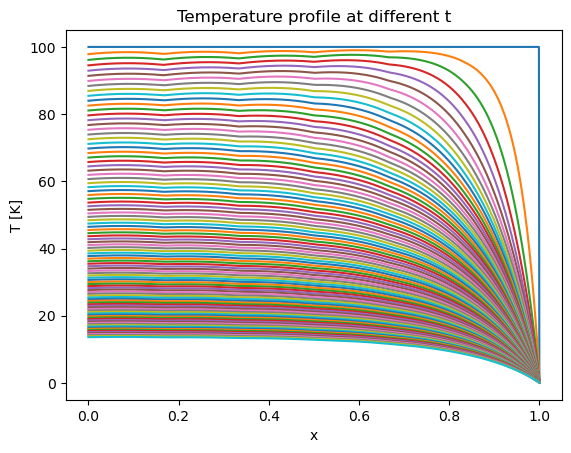

In [73]:
x_interp = np.linspace(Xs[0], Xs[-1], 1000)

dx2 = x_interp[1]-x_interp[0]
alpha2 = dt/dx2**2

time = np.arange(dt, tsteps+dt, dt)

#linear interpolation to estimate kappa for new x values
K_interp = np.interp(x_interp, Xs, Ks)

T2, A2, b2 = matrices(K_interp, len(K_interp), alpha2) 

plt.plot(x_interp, T2)
for i in time:
    #solve
    T2 = scipy.linalg.solve_banded((1,1), A2, T2 + alpha2*b2)
    if i == 1:
        print('After 1 second, \n T(x=0) = ', T2[0], 'K')
        break
    plt.plot(x_interp, T2)
plt.xlabel('x')
plt.ylabel('T [K]')
plt.title('Temperature profile at different t')
plt.show()

## 4. Neutron stars merging

### Generate random sample of 100 values of $\tau$

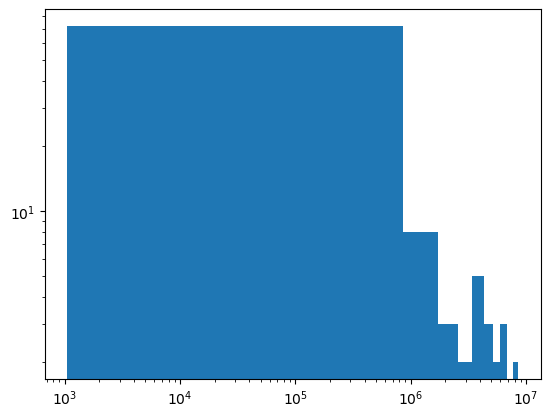

In [55]:
Nelements = 100
tsteps = 10**6
dt = 10**1
time = np.arange(0,tsteps)
N_atoms = np.zeros((tsteps, Nelements))


#initially, all elements have same number of atoms
#at t=0
N_atoms[0] = 1e6
#print(N_atoms)

#generate random sample of 100 values of Tau
decay_T = 10**np.random.uniform(3., 7., Nelements) 

#check this is distributed in log_10 space
plt.hist(decay_T)
plt.xscale('log')
plt.yscale('log')

#Yes! these are in a log space distribution

### Integrate the decay of 100 elements over time

**Numerical integration using backward Euler method**


$$
N^i = N^{i-1} + \dfrac{dN_i}{dt}\Delta t
$$

In [54]:
def dN_dt(N, T):
    '''Define derivative to describe the amount an element decays over time'''
    return -N/T

def integrate_euler(tsteps, dt, N0, derivs):
    '''This function implements the euler method of integration
       N = array of elements at all times
       E = array of total energy at all times
       
       Returns N, E after being updated for tsteps'''
    
    N = np.zeros((tsteps, len(N0)))
    E = np.zeros(tsteps)
    E[0] = np.sum(N_atoms[0]/decay_T)
    N[0] = N0
    
    for i in range(1, tsteps-1):
        #call derivatives
        f = derivs(N[i-1], decay_T)
        #euler method
        N[i] = N[i-1] + f*dt
        #compute energy
        E[i] = np.sum(N[i]/decay_T)
    return N, E

#call function
N_integrated, E = integrate_euler(tsteps, dt, [1e6]*Nelements, dN_dt)

Text(0, 0.5, 'Total energy')

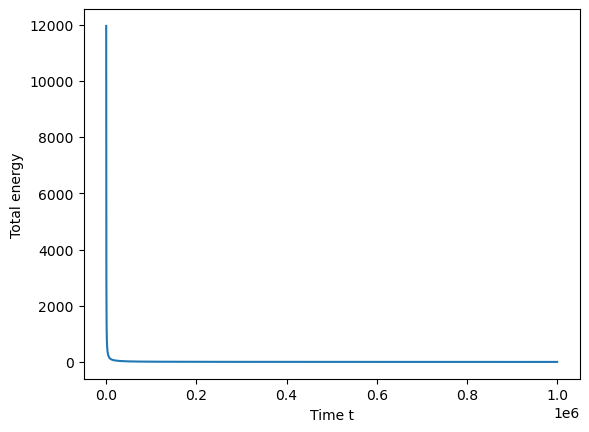

In [63]:
plt.plot(time, E)
#plt.plot(time[1:], 1/time[1:])
plt.xlabel('Time t')
plt.ylabel('Total energy')

**Analytical approach**

Differential equation
$$
\dfrac{dN}{dt} = -\dfrac{N}{\tau}
$$

has an exponential solution of the form:
$$
N(t) = N_0e^{-t/\tau}
$$

In [64]:
E_total = np.zeros(tsteps)
E_total[0] = np.sum(N_atoms[0]/decay_T) #

for t in range(1, tsteps): 
    #exponential decay -> N = N0 e^-t/T
    N_atoms[t] = N_atoms[0] * np.exp(-t/decay_T)
    E_total[t] = np.sum(N_atoms[t]/decay_T)
    # - to indicate it is released
    #print(E_total[t])

<function matplotlib.pyplot.xscale(value, **kwargs)>

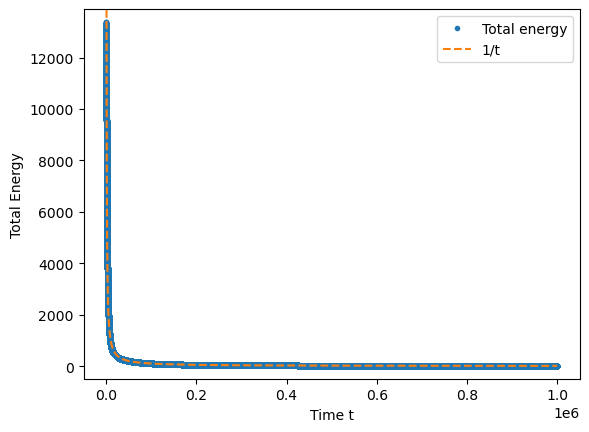

In [65]:
#plot energy over time
plt.plot(time, E_total, '.', label='Total energy')
plt.xlabel('Time t')
plt.ylabel('Total Energy')
plt.plot(time[1:], 10e6/time[1:], label='1/t', linestyle='--')
#plt.plot(time[1:], 1e2*np.exp(-1/time[1:]), label='1/t', linestyle='--')
plt.ylim(min(E_total)-500, max(E_total)+500)
#plt.ylim(-100,100)
plt.legend()
plt.xscale

The two methods agree in the decay behaviour of the energy. 

The above plots shows that Li and Paczynski's prediction that the total energy per second follows a power law proportional to $1/t$ is correct. 

Looking at the differential equation
$$
\dfrac{dN}{dt} = \dfrac{-N}{\tau}
$$

we would assume that the solution to this ODE is of an exponential form for each element, as shown above. However, the fact that the decay follows a power-law is due to the distribution of the decay timescales. When we have a wide range of decay timescales, as we do, the exponential decay for each elements contributes differently to the overall process, and therefore to the total energy. Elements with a short $\tau$ decay more quickly, while those with longer $\tau$ will stay for a longer time. The combined behaviour seems to be described by a power law decay. 